In [1]:
!nvidia-smi

Mon Mar 25 10:25:20 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:67:00.0 Off |                  N/A |
|  0%   20C    P8    28W / 350W |    539MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
from torchvision import models
# from torchsummary import summary as model_summary
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input
class FCN(nn.Module):
    def __init__(self, num_hologram):
        super(FCN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        )  # 256
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        )  # 128
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        )  # 64
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        )  # 32
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1)
        )  # 16
        self.block6 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1)
        )  # 8
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(1024, 1024, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(64)
        self.deconv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn6     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, num_hologram, kernel_size=1)
        
    def forward(self, x):
        # print(x.shape)
        x = self.block1(x)
        # print(x.shape)
        x1 = x
        x = self.block2(x)
        # print(x.shape)
        x2 = x
        x = self.block3(x)
        # print(x.shape)
        x3 = x
        x = self.block4(x)
        # print(x.shape)
        x4 = x
        x = self.block5(x)
        # print(x.shape)
        x5 = x
        x = self.block6(x)

        x6 = x
        # print(x5.shape)
        score = self.deconv1(x6)
        # print(score.shape)
        score = self.bn1(self.relu(score))     # size=(N, 512, x.H/16, x.W/16)
        # print(score.shape, x4.shape)
        score = score + x5                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn6(self.relu(self.deconv6(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        # print(score.shape)
        score = torch.nn.Tanh()(score)
        return SignFunction.apply(score)

# model = FCN().to('cuda')
# model_summary(model, (1,1088,2048))

In [3]:
import torchOptics.optics as tt
import warnings 
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torchvision.transforms as trnasforms
import torch
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import glob
import math
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}

In [4]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [5]:
def get_psnr(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * torch.log10((PIXEL_MAX ** 2) / mse)

In [6]:
import torch.nn.functional as F
import torchvision
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.resize = torchvision.transforms.CenterCrop(512)

    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray = True)
        # print(target.shape)
        target = target.unsqueeze(0)
        target = self.resize(target)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target

In [7]:
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir = target_dir, meta = meta)
valid_dataset = Dataset512(target_dir = valid_dir, meta = meta)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torchOptics.metrics as tm
import torch.nn.functional as F
import tqdm as tqdm
# writer = SummaryWriter()
writer = SummaryWriter()
# model = test()
num_hologram = 50
lr = 1e-4
epochs = 100
z = 2e-3
model = FCN(num_hologram=num_hologram)
model = model.to('cuda')
# factor = torch.Tensor([20]).to('cuda')
# factor.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sign_function = SignFunction.apply
path = 'models/'
# valid_image = valid_dataset[0]
for epoch in range(epochs):
    pbar = tqdm.tqdm(trainloader)
    model.train()
    for target in pbar:
        out = model(target)
        # binary = sign_function(out)
        sim = tt.simulate(out, z).abs()**2
        result = torch.mean(sim, dim=1, keepdim=True)
        loss = tt.relativeLoss(result, target, F.mse_loss)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        psnrList = []
        mseList = []
        for valid in validloader:
            out = model(valid)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
            psnrList.append(psnr)
            mse = tt.relativeLoss(result, valid, F.mse_loss)
            mseList.append(mse)
        mean_psnr = sum(psnrList)/len(psnrList)
        mean_mse = sum(mseList)/len(mseList)
        writer.add_scalar("mean_PSNR/valid", mean_psnr, epoch)
        writer.add_scalar("mean_MSE/valid", mean_mse, epoch)
        print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
        print(f'mean MSE : {mean_mse} {epoch}/{epochs}')
    torch.save(model, path + 'fcn_binary_image_num.pt')
writer.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:27<00:00,  9.14it/s]


mean PSNR : 21.981656494140626 0/100
mean MSE : 0.00722901988774538 0/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:37<00:00,  8.17it/s]


mean PSNR : 23.339920845031738 1/100
mean MSE : 0.005474184639751911 1/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:48<00:00,  7.40it/s]


mean PSNR : 23.857307090759278 2/100
mean MSE : 0.004848902579396963 2/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:33<00:00,  8.60it/s]


mean PSNR : 24.281586303710938 3/100
mean MSE : 0.0044525908306241035 3/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:49<00:00,  7.28it/s]


mean PSNR : 24.40244613647461 4/100
mean MSE : 0.00430918438360095 4/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:59<00:00,  6.68it/s]


mean PSNR : 24.60499285697937 5/100
mean MSE : 0.004122223239392042 5/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.27it/s]


mean PSNR : 24.781092004776 6/100
mean MSE : 0.003967728931456804 6/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.25it/s]


mean PSNR : 24.958558740615846 7/100
mean MSE : 0.0038199154660105705 7/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.32it/s]


mean PSNR : 24.885840711593627 8/100
mean MSE : 0.003843827871605754 8/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:56<00:00,  6.88it/s]


mean PSNR : 25.011279640197753 9/100
mean MSE : 0.003720772685483098 9/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:00<00:00,  6.64it/s]


mean PSNR : 24.904166498184203 10/100
mean MSE : 0.003758929204195738 10/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.57it/s]


mean PSNR : 24.927409019470215 11/100
mean MSE : 0.0036837453953921795 11/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.30it/s]


mean PSNR : 25.133438386917113 12/100
mean MSE : 0.0035239735152572393 12/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.26it/s]


mean PSNR : 25.283501472473144 13/100
mean MSE : 0.0034164029639214277 13/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.21it/s]


mean PSNR : 25.19033811569214 14/100
mean MSE : 0.0034543597139418125 14/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.28it/s]


mean PSNR : 25.263761291503908 15/100
mean MSE : 0.0033892758656293154 15/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.26it/s]


mean PSNR : 25.751542205810548 16/100
mean MSE : 0.0030951618682593107 16/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.33it/s]


mean PSNR : 25.923675212860108 17/100
mean MSE : 0.002980818273499608 17/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.28it/s]


mean PSNR : 26.065053749084473 18/100
mean MSE : 0.002879904117435217 18/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.32it/s]


mean PSNR : 26.29840717315674 19/100
mean MSE : 0.0027347386348992586 19/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.30it/s]


mean PSNR : 26.224710159301758 20/100
mean MSE : 0.002753267763182521 20/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:32<00:00,  8.62it/s]


mean PSNR : 26.576938438415528 21/100
mean MSE : 0.0025784254539757967 21/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:53<00:00,  7.03it/s]


mean PSNR : 26.501668300628662 22/100
mean MSE : 0.0026040917728096247 22/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.37it/s]


mean PSNR : 26.69674587249756 23/100
mean MSE : 0.002498710760846734 23/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.27it/s]


mean PSNR : 26.7676060295105 24/100
mean MSE : 0.0024549642112106085 24/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:33<00:00,  8.59it/s]


mean PSNR : 26.85254249572754 25/100
mean MSE : 0.002405618317425251 25/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:59<00:00,  6.71it/s]


mean PSNR : 26.71473752975464 26/100
mean MSE : 0.0024485522881150246 26/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:51<00:00,  7.19it/s]


mean PSNR : 26.954896392822267 27/100
mean MSE : 0.002365169581025839 27/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.57it/s]


mean PSNR : 26.705332832336424 28/100
mean MSE : 0.002449032384902239 28/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:30<00:00,  8.88it/s]


mean PSNR : 27.160034618377686 29/100
mean MSE : 0.002248059492558241 29/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.32it/s]


mean PSNR : 26.401962051391603 30/100
mean MSE : 0.0026208043564110994 30/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.29it/s]


mean PSNR : 27.16001895904541 31/100
mean MSE : 0.0022451241966336966 31/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:31<00:00,  8.79it/s]


mean PSNR : 27.311045436859132 32/100
mean MSE : 0.002185382880270481 32/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.56it/s]


mean PSNR : 27.229283981323242 33/100
mean MSE : 0.0022155672777444124 33/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.57it/s]


mean PSNR : 27.2291109085083 34/100
mean MSE : 0.002310761483386159 34/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.57it/s]


mean PSNR : 27.15571828842163 35/100
mean MSE : 0.002219820162281394 35/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:52<00:00,  7.12it/s]


mean PSNR : 27.423347091674806 36/100
mean MSE : 0.002127093728631735 36/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.29it/s]


mean PSNR : 27.38908260345459 37/100
mean MSE : 0.0021420426201075315 37/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.22it/s]


mean PSNR : 27.344783477783203 38/100
mean MSE : 0.002150928368791938 38/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.28it/s]


mean PSNR : 27.477749042510986 39/100
mean MSE : 0.0021019314881414175 39/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.31it/s]


mean PSNR : 27.56622455596924 40/100
mean MSE : 0.0020458137150853872 40/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.38it/s]


mean PSNR : 27.39482683181763 41/100
mean MSE : 0.002112884074449539 41/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.29it/s]


mean PSNR : 27.386795349121094 42/100
mean MSE : 0.00212122336961329 42/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.26it/s]


mean PSNR : 27.353105716705322 43/100
mean MSE : 0.0021281272638589144 43/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.25it/s]


mean PSNR : 27.77199010848999 44/100
mean MSE : 0.00197237660177052 44/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.29it/s]


mean PSNR : 27.767944564819334 45/100
mean MSE : 0.0019714899826794863 45/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.22it/s]


mean PSNR : 27.780989742279054 46/100
mean MSE : 0.001966502284631133 46/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.26it/s]


mean PSNR : 27.68008462905884 47/100
mean MSE : 0.002007240429520607 47/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.24it/s]


mean PSNR : 27.650559310913085 48/100
mean MSE : 0.002033564727753401 48/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.30it/s]


mean PSNR : 27.354025268554686 49/100
mean MSE : 0.0021241845097392797 49/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.29it/s]


mean PSNR : 27.436070060729982 50/100
mean MSE : 0.0020838382188230753 50/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:49<00:00,  7.33it/s]


mean PSNR : 27.246667976379396 51/100
mean MSE : 0.0021560019813477993 51/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.57it/s]


mean PSNR : 27.75058483123779 52/100
mean MSE : 0.001972498605027795 52/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.58it/s]


mean PSNR : 27.563306274414064 53/100
mean MSE : 0.002032647607848048 53/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.58it/s]


mean PSNR : 27.87387212753296 54/100
mean MSE : 0.0019180834060534835 54/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.58it/s]


mean PSNR : 27.73641326904297 55/100
mean MSE : 0.0019594095647335052 55/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:32<00:00,  8.69it/s]


mean PSNR : 27.986344509124756 56/100
mean MSE : 0.001875406363978982 56/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.27it/s]


mean PSNR : 27.594550857543947 57/100
mean MSE : 0.0020034632179886103 57/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:53<00:00,  7.08it/s]


mean PSNR : 27.9218088722229 58/100
mean MSE : 0.0018903773743659258 58/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.60it/s]


mean PSNR : 27.727204856872557 59/100
mean MSE : 0.001962459646165371 59/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.60it/s]


mean PSNR : 27.671275577545167 60/100
mean MSE : 0.0019933306612074375 60/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.59it/s]


mean PSNR : 28.060388450622558 61/100
mean MSE : 0.001847206731326878 61/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.59it/s]


mean PSNR : 27.9794575881958 62/100
mean MSE : 0.0018764896085485816 62/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.59it/s]


mean PSNR : 27.84780517578125 63/100
mean MSE : 0.0019045629305765033 63/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.59it/s]


mean PSNR : 27.868353881835937 64/100
mean MSE : 0.0019085350213572383 64/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.58it/s]


mean PSNR : 28.16206485748291 65/100
mean MSE : 0.0018158903112635016 65/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.58it/s]


mean PSNR : 27.908829193115235 66/100
mean MSE : 0.0018826451851055026 66/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.58it/s]


mean PSNR : 27.77796953201294 67/100
mean MSE : 0.0019256065133959055 67/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.59it/s]


mean PSNR : 28.034982757568358 68/100
mean MSE : 0.0018436015816405416 68/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.57it/s]


mean PSNR : 28.090851440429688 69/100
mean MSE : 0.0018221052596345544 69/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:01<00:00,  6.57it/s]


mean PSNR : 27.926973361968994 70/100
mean MSE : 0.0018920633010566235 70/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:00<00:00,  6.62it/s]


mean PSNR : 27.821209335327147 71/100
mean MSE : 0.0019406203646212816 71/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.22it/s]


mean PSNR : 28.00031209945679 72/100
mean MSE : 0.0018579130992293358 72/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.24it/s]


mean PSNR : 27.583639030456542 73/100
mean MSE : 0.0019908894319087267 73/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.24it/s]


mean PSNR : 27.978524074554443 74/100
mean MSE : 0.0018772801849991083 74/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:27<00:00,  9.14it/s]


mean PSNR : 27.5839217376709 75/100
mean MSE : 0.0020454952027648687 75/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:37<00:00,  5.08it/s]


mean PSNR : 27.27936706542969 76/100
mean MSE : 0.002087194938212633 76/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:58<00:00,  4.49it/s]


mean PSNR : 27.322706050872803 77/100
mean MSE : 0.0020782477222383022 77/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:58<00:00,  4.49it/s]


mean PSNR : 28.1280318069458 78/100
mean MSE : 0.001805874053388834 78/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:58<00:00,  4.49it/s]


mean PSNR : 27.853197479248045 79/100
mean MSE : 0.0018772772746160626 79/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:34<00:00,  5.16it/s]


mean PSNR : 27.79184274673462 80/100
mean MSE : 0.0019112317822873592 80/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.37it/s]


mean PSNR : 27.91530235290527 81/100
mean MSE : 0.0018725129775702953 81/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.34it/s]


mean PSNR : 27.762051486968993 82/100
mean MSE : 0.0019252095371484756 82/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.34it/s]


mean PSNR : 27.68712594985962 83/100
mean MSE : 0.0019440565956756473 83/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.33it/s]


mean PSNR : 27.24360767364502 84/100
mean MSE : 0.0021218324545770884 84/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.27it/s]


mean PSNR : 28.20284025192261 85/100
mean MSE : 0.001778068020939827 85/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.29it/s]


mean PSNR : 27.935733909606935 86/100
mean MSE : 0.0018738515209406614 86/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.31it/s]


mean PSNR : 28.25280122756958 87/100
mean MSE : 0.0017766476375982165 87/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.33it/s]


mean PSNR : 28.246808013916016 88/100
mean MSE : 0.0017886480782181025 88/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.28it/s]


mean PSNR : 28.29630859375 89/100
mean MSE : 0.0017397872870787978 89/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.27it/s]


mean PSNR : 28.301997928619386 90/100
mean MSE : 0.0017402387456968427 90/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.27it/s]


mean PSNR : 27.96266418457031 91/100
mean MSE : 0.0018432014621794224 91/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.31it/s]


mean PSNR : 27.81362588882446 92/100
mean MSE : 0.001919107511639595 92/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.35it/s]


mean PSNR : 28.0748201751709 93/100
mean MSE : 0.0018160073086619377 93/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.28it/s]


mean PSNR : 28.354067096710207 94/100
mean MSE : 0.0017166654579341412 94/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.26it/s]


mean PSNR : 28.2855863571167 95/100
mean MSE : 0.0017446165438741446 95/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.25it/s]


mean PSNR : 28.251573944091795 96/100
mean MSE : 0.0017510197358205914 96/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:38<00:00,  8.08it/s]


mean PSNR : 28.094181613922117 97/100
mean MSE : 0.001805148203857243 97/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:58<00:00,  4.49it/s]


mean PSNR : 28.176050872802733 98/100
mean MSE : 0.0017760861665010452 98/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:58<00:00,  4.49it/s]


mean PSNR : 27.999317531585692 99/100
mean MSE : 0.0018317191861569881 99/100


In [11]:
model = torch.load('models/fcn_binary_image_num.pt')
sign_function = SignFunction.apply
z = 2e-3
with torch.no_grad():
    psnrList = []
    mseList = []
    for valid in validloader:
        out = model(valid)
        binary = sign_function(out)
        sim = tt.simulate(binary, z).abs()**2
        result = torch.mean(sim, dim=1, keepdim=True)
        psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
        psnrList.append(psnr)
        mse = tt.relativeLoss(result, valid, F.mse_loss)
        mseList.append(mse)
    print('PSNR', sum(psnrList)/len(psnrList), 'MSE', sum(mseList)/len(mseList))

PSNR 27.999318141937255 MSE 0.0018317189533263445



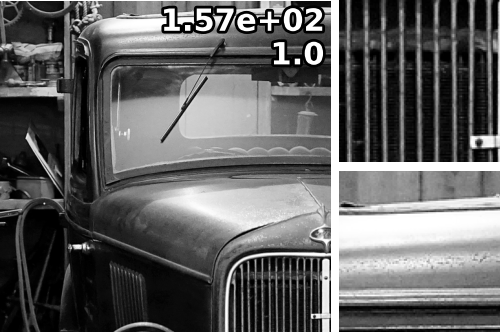

In [12]:
tt.show_with_insets(valid, valid)


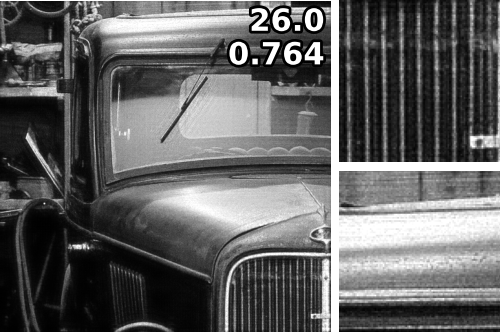

In [13]:
tt.show_with_insets(result, valid)


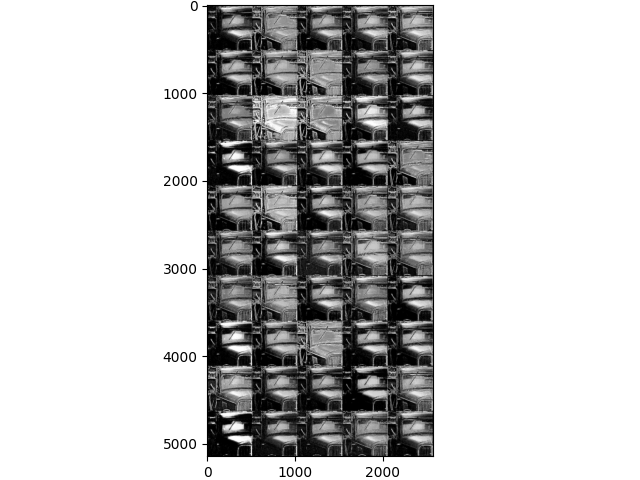

In [14]:
tt.show(binary)

In [15]:
with torch.no_grad():
    # psnrList = []
    # mseList = []
    # for valid in validloader:
    input = valid_dataset[0].unsqueeze(0)
    out = model(input)
    binary = sign_function(out)
    sim = tt.simulate(binary, z).abs()**2
    result = torch.mean(sim, dim=1, keepdim=True)
    psnr = tt.relativeLoss(result, input, tm.get_PSNR)
    # psnrList.append(psnr)
    mse = tt.relativeLoss(result, input, F.mse_loss)
    # mseList.append(mse)


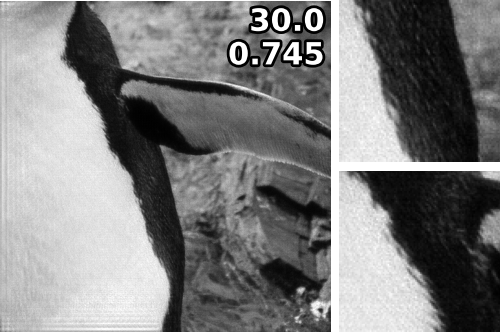

In [18]:
tt.show_with_insets(result, input)


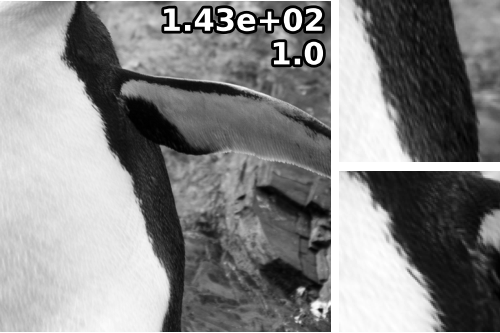

In [19]:
tt.show_with_insets(input, input)

In [ ]:
tt.